# Parameter scan for the LHC data set

In [21]:
import sys
import numpy as np
import optuna
import pickle
from matplotlib import pyplot as plt
import pandas as pd


In [28]:
ids = list(range(25))
studies = [pickle.load(open(f"../data/paramscan/paramscan_{i}.pickle", "rb")) for i in ids]
trials = [study.trials_dataframe() for study in studies]


In [34]:
for i, trial in enumerate(trials):
    trial.index = [f"job_{i}_trial_{j}" for j in trial["number"]]
    trial.drop(["number", "system_attrs__number", "state"], axis=1)

results = pd.concat(trials)
results = results.sort_values(by="value", ascending=True)


In [41]:
results.columns

Index(['number', 'value', 'datetime_start', 'datetime_complete',
       'params_batchsize', 'params_clip', 'params_dropout', 'params_msefactor',
       'params_outerlayers', 'params_splinebins', 'params_splinerange',
       'params_weightdecay', 'system_attrs__number', 'state'],
      dtype='object')

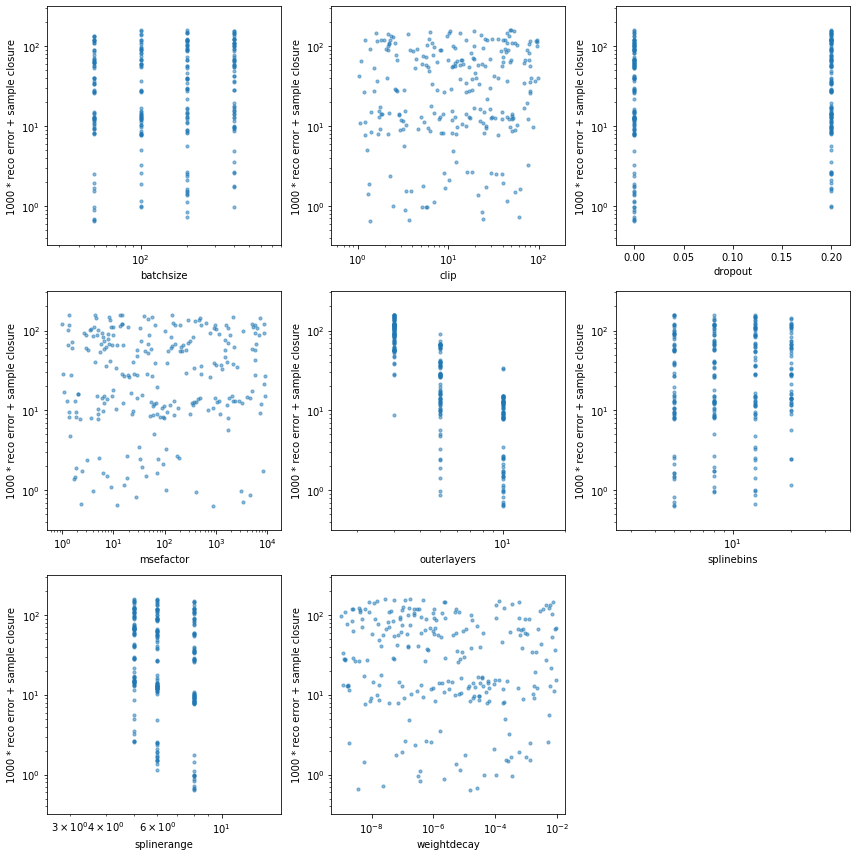

In [53]:
params = [c.replace("params_", "") for c in result.columns if "params_" in c]
n = len(params)
ncols = 3
nrows = (n - 1) // ncols + 1

plt.figure(figsize=(ncols * 4, nrows * 4))

for i, param in enumerate(params):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.scatter(results[f"params_{param}"], results["value"], s=10., alpha=0.5)
    plt.xlabel(param)
    plt.ylabel("1000 * reco error + sample closure")
    
    plt.ylim(0.5 * results["value"].min(), 2.*results["value"].max())
    plt.yscale("log")
    if param in ["batchsize", "clip", "msefactor", "outerlayers", "splinebins", "splinerange", "weightdecay"]:
        plt.xscale("log")
        plt.xlim(0.5 * results[f"params_{param}"].min(), 2.*results[f"params_{param}"].max())
    
plt.tight_layout()
plt.savefig("../figures/lhc_paramscan.pdf")
